In [1]:
import numpy as np
import pylab as pl
from pykalman import UnscentedKalmanFilter
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import os
from utils_kalman import *

# 0. Test without using kalman filter
A test to get track the camera movement only by the video.
1.  try to seperate the optical flow generated by translatio and rotation (by the nature of optical flow).
2.  get the rotation from the optical flow, as rotation will generate a optical flow in the direction of the movement.
3. estimation of the translation
![title](img/optical_flow.png)

In [18]:
video_file = 'test_6_25/video905.h264'
ang1 = rotate_from_video(video_file)
dis, ang2 = rotate_and_translation_from_video(video_file)
print(ang1, ang2, dis)

3.720302975177765 -0.8958076232138648 21.049963248901896


In [26]:
def points_from_dist_angle(dist, angle):
    num = len(dist)
    points = np.zeros((num+1,2))
    ang = 0
    for i in range(num):
        ang = ang + angle[i]
        points[i+1,0] = points[i,0] - dist[i]*np.sin(ang*np.pi/180)
        points[i+1,1] = points[i,1] + dist[i]*np.cos(ang*np.pi/180)
    return points

def get_matrix_from_video(videofile):
    ang1 = rotate_from_video(video_file)
    dis, ang2 = rotate_and_translation_from_video(video_file)
    if ang2 < 20:
        dis = 0
        ang = ang1
    else:
        ang = ang2
    r = np.array([ang,0,0])
    t = np.array([0,dis*np.sin(ang*np.pi/180),dis*np.cos(ang*np.pi/180)])
    return trans_matrix(r,t)

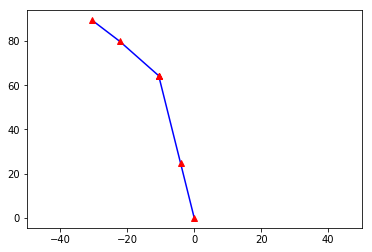

In [28]:
dist = []
angle = []
for i in range(0,6):
    video_file = 'test_6_25/video80'+str(i)+'.h264'
    dis = 0
    if i == 2 or i == 3 :
        ang = rotate_from_video(video_file)
    else:
        dis, ang = rotate_and_translation_from_video(video_file)
    dist.append(dis)
    angle.append(ang)
points = points_from_dist_angle(dist, angle)
pl.figure()
pl.plot(points[:,0] ,points[:,1], color='b')
pl.plot(points[:,0] ,points[:,1], 'r^')
pl.xlim((-50, 50))
pl.show()

# 1. Kalman Filter
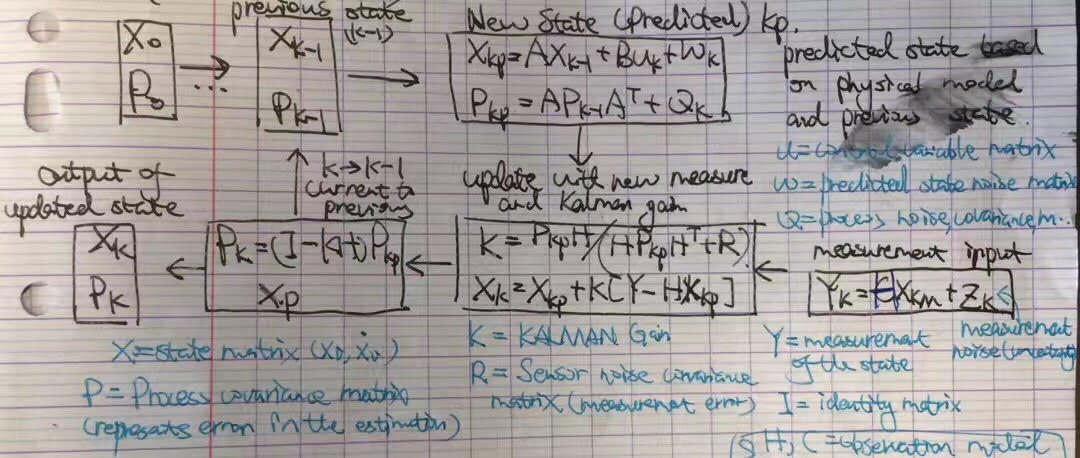

we use the SURF feature detector to detect feature points,
and we use Lucas-Kanada method to match the points to get a optical flow (a flow of feature points shared by all the images)

## 1.0 state
1. the state is { x , y , theta, vx, vy, vtheta, {xi, yi}(for n feature points) }.
2. the observation is {distance, angle} of the featrue points from the robot point of view.
3. the state is a (6+2n) array.

In [2]:
video_file = '4/video4.h264'
dep = np.load('4/dep4.npy')
dep0 = cv2.resize(dep[0,:,:,0], (video_width ,video_height))
filtered_state_estimates, smoothed_state_estimates = kalman_filter(video_file, dep0, 0.33)

feature points shape from optical flow is  (19, 5, 1, 2)
new points is  (19, 5, 1, 2)
[[630.65693431   0.         240.        ]
 [  0.         627.79291553 320.        ]
 [  0.           0.           1.        ]]
initilization shape is  (16,)
observation shape is  (18, 5)


## 1.1 Test results
### 1.1.0 Build kalman filter model and test

In [65]:
points, init_image = get_feature_points_from_video(video_file)
i, o = feature_points_to_observation_and_initilization(points, 0, dep0)

feature points shape from optical flow is  (19, 5, 1, 2)
new points is  (19, 5, 1, 2)
[[630.65693431   0.         240.        ]
 [  0.         627.79291553 320.        ]
 [  0.           0.           1.        ]]


In [41]:
observations = np.asarray(o[0:5])
n = observations.shape[1]
print('initilization shape is ', i.shape)
print('observation shape is ', observations.shape)
# initialize the vovariance and mean
transition_covariance = np.eye(2*n+6)
random_state = np.random.RandomState(0)
observation_covariance = np.eye(n) + abs(random_state.randn(n, n) * 0.5)

initial_state_mean = i
covariance_init = random_state.randn(2*n+6, 2*n+6) * 0.1
covariance_init[0:6,0:6] = 0.005
initial_state_covariance =  np.eye(2*n+6) + abs(covariance_init)
# set Unscented kalman filter
kf = UnscentedKalmanFilter(
        transition_function, observation_function,
        transition_covariance, observation_covariance,
        initial_state_mean, initial_state_covariance,
        random_state=random_state
        )
filtered_state_estimates = kf.filter(observations)

initilization shape is  (16,)
observation shape is  (5, 5)


In [44]:
observations = np.asarray(o[5:-1])
kf = UnscentedKalmanFilter(
        transition_function, observation_function,
        transition_covariance, observation_covariance,
        filtered_state_estimates[0][-1], filtered_state_estimates[1][-1],
        random_state=random_state
        )
filtered_state_estimates = kf.filter(observations)

### 1.1.1 The evaluation of the state of X

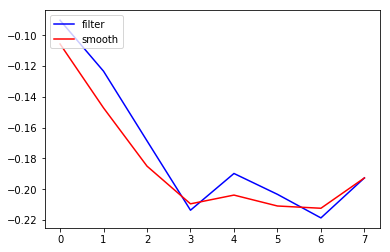

In [4]:
# draw estimates
pl.figure()
lines_true = pl.plot(filtered_state_estimates[:,0] , color='b')
lines_ukf = pl.plot(smoothed_state_estimates[:,0], color='r', ls='-')
pl.legend((lines_true[0], lines_ukf[0]),('filter', 'smooth'),loc='upper left')
pl.show()

### 1.1.2 The obseravtions

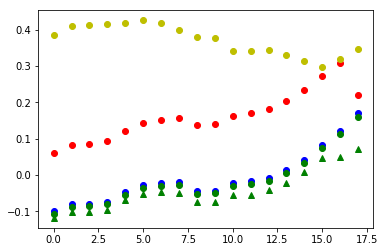

In [70]:
x = np.arange(len(o[:,0]))
plt.plot(x, o[:,0],'ro',x,o[:,1],'bo',x,o[:,2],'go',x,o[:,3],'yo',x,o[:,4],'g^')

### 1.1.3 The velocity of the angle

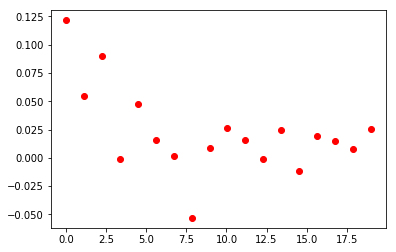

In [46]:
dx = filtered_state_estimates[:,10] - filtered_state_estimates[:,0]
dy = filtered_state_estimates[:,11] - filtered_state_estimates[:,1]
theta = np.arctan2(dx,dy)
plt.plot(x,theta , 'ro' )

## 1.2 Make animation images

In [8]:
def from_KF_result_to_points(estimate):
    num = int((len(estimate) - 6)/2)
    x = np.zeros(num)
    y = np.zeros(num)
    for i in range(num):
        x[i] = estimate[6+2*i]
        y[i] = estimate[6+2*i+1]
    return x,y

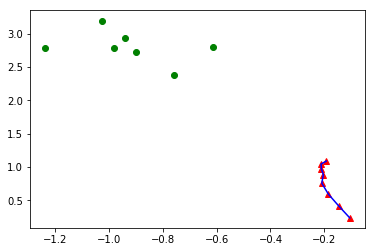

In [13]:
num_obs = filtered_state_estimates.shape[0]
ims = []
fig = plt.figure()
for i in range(num_obs):
    x1,y1 = from_KF_result_to_points(filtered_state_estimates[i])
    im = plt.plot( x1,y1, 'go',
        smoothed_state_estimates[0:i+1,0],smoothed_state_estimates[0:i+1,1], 'r^',
        smoothed_state_estimates[0:i+1,0],smoothed_state_estimates[0:i+1,1], 'b')
    ims.append(im)
    
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')
plt.show()

1. The green points are the feature points, they are initialized at 2 meters, after the observations the system made a good estiamtio of their positions.
2. The red triangles are the robot positions and blue line is the trajectoire. The system predicts well the movement of the robot

### 1.2.1 For two processes

In [43]:
def make_animation( smoothed_state_estimates1, smoothed_state_estimates2):
    ims = []
    num_obs1 = smoothed_state_estimates1.shape[0]
    for i in range(num_obs1):
        x1,y1 = from_KF_result_to_points(smoothed_state_estimates1[i])
        im = plt.plot( x1,y1, 'go',
            smoothed_state_estimates1[0:i+1,0],smoothed_state_estimates1[0:i+1,1], 'r^',
            smoothed_state_estimates1[0:i+1,0],smoothed_state_estimates1[0:i+1,1], 'b')
        ims.append(im)
    ori = [smoothed_state_estimates1[num_obs1-1,0],-smoothed_state_estimates1[num_obs1-1,1]/4]
    
    num_obs2 = smoothed_state_estimates2.shape[0]
    for i in range(num_obs2):
        x0,y0 = from_KF_result_to_points(smoothed_state_estimates1[num_obs1-1])
        x1,y1 = from_KF_result_to_points(smoothed_state_estimates2[i])
        im = plt.plot( x1+ori[0],y1+ori[1], 'bo',x0,y0, 'go',
            smoothed_state_estimates2[0:i+1,0]+ori[0],smoothed_state_estimates2[0:i+1,1]+ori[1], 'y^',
            smoothed_state_estimates2[0:i+1,0]+ori[0],smoothed_state_estimates2[0:i+1,1]+ori[1], 'b',
            smoothed_state_estimates1[0:num_obs1,0],smoothed_state_estimates1[0:num_obs1,1], 'r^',
            smoothed_state_estimates1[0:num_obs1,0],smoothed_state_estimates1[0:num_obs1,1], 'b')
        ims.append(im) 
    return ims

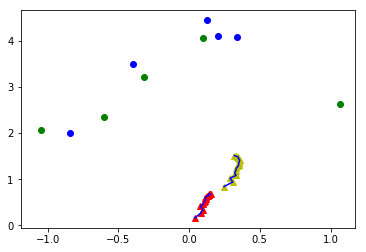

In [44]:
fig = plt.figure()
smoothed_state_estimates1 = np.load('4/smoothed_state_estimates3.npy')
smoothed_state_estimates2 = np.load('4/smoothed_state_estimates4.npy')
ims = make_animation( smoothed_state_estimates1, smoothed_state_estimates2)
ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')
plt.show()

## 1.3 Another test result

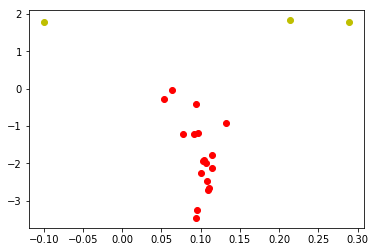

In [42]:
plt.plot(filtered_state_estimates[:,0], filtered_state_estimates[:,1], 'ro')
#plt.plot(from_KF_result_to_points(filtered_state_estimates[17]), 'go')
x1,y1 = from_KF_result_to_points(filtered_state_estimates[0])
plt.plot(x1,y1, 'yo')
#plt.axis([-5, 5, -5, 5])
plt.show()

## 2. Summary
1. However in this system we can only predict distance for limit points, which is not enough for our objective to create a complete world model.
2. And this kalman filter package are designed for static shape of the "state" vector. But in real running robot, we need to add new feature points, which demands us to create our own Kalman filter algorithm. That is possible, as we have done a extended kalman filter our own before, but we are facing problem 1 too.
3. As a result, we decided to switch to another solution